In [1]:
import meep as mp
import meep.adjoint as mpa
import autograd.numpy as npa
import numpy as np
from matplotlib import pyplot as plt
import nlopt
mp.quiet(quietval=True)

Using MPI version 3.1, 1 processes


In [2]:
waveguide_width = 0.5
design_region_width = 2
design_region_height = 2
arm_separation = 1
resolution = 30
design_region_resolution = resolution

In [3]:
Sx = 5
Sy = 4.5
cell_size = mp.Vector3(Sx,Sy)

pml_layers = [mp.PML(1.0)]

fcen = 1/1.55
width = 0.2
fwidth = width * fcen
source_center  = [-1.4,0,0]
source_size    = mp.Vector3(0,2,0)
kpoint = mp.Vector3(1,0,0)
src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
source = [mp.EigenModeSource(src,
                    eig_band = 1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size = source_size,
                    center=source_center)]

seed = 24
np.random.seed(seed)
Nx = design_region_resolution * design_region_width
Ny = int(design_region_resolution * design_region_height/2)

design_region = mp.Volume(center=mp.Vector3(), size=mp.Vector3(design_region_width, design_region_height, 0))
rho_vector = 11*np.random.rand(Nx*Ny) + 1
design_variables = mpa.BilinearInterpolationBasis(volume=design_region,Nx=Nx,Ny=Ny,rho_vector=rho_vector,symmetry=[])

geometry = [
    mp.Block(center=mp.Vector3(x=-Sx/4), material=mp.Medium(index=3.45), size=mp.Vector3(Sx/2+1, waveguide_width, 0)), # left waveguide
    mp.Block(center=mp.Vector3(x=Sx/4, y=arm_separation/2), material=mp.Medium(index=3.45), size=mp.Vector3(Sx/2+1, waveguide_width, 0)), # top right waveguide
    mp.Block(center=mp.Vector3(x=Sx/4, y=-arm_separation/2), material=mp.Medium(index=3.45), size=mp.Vector3(Sx/2+1, waveguide_width, 0)), # bottom right waveguide
    mp.Block(center=design_region.center, size=design_region.size, epsilon_func=design_variables.func()) # design region
]

sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    #symmetries=[mp.Mirror(direction=mp.Y)],
                    resolution=resolution)

In [4]:
mode = 1

TE0 = mpa.EigenmodeCoefficient(sim,mp.Volume(center=mp.Vector3(x=-1.2),size=mp.Vector3(y=1.5)),mode)
TE_top = mpa.EigenmodeCoefficient(sim,mp.Volume(center=mp.Vector3(1.2,arm_separation/2,0),size=mp.Vector3(y=1)),mode)
TE_bottom = mpa.EigenmodeCoefficient(sim,mp.Volume(center=mp.Vector3(1.2,-arm_separation/2,0),size=mp.Vector3(y=1)),mode)
ob_list = [TE0,TE_top,TE_bottom]

In [5]:
def J(source,top,bottom):
    return npa.mean(npa.abs(top/source) ** 2 + npa.abs(bottom/source) ** 2)

In [6]:
nf = 1 # number of frequency points to simulate
opt = mpa.OptimizationProblem(
    simulation = sim,
    objective_functions = J,
    objective_arguments = ob_list,
    design_variables = [design_variables],
    fcen = fcen,
    df = fwidth,
    nf = nf,
    decay_by = 1e-4,
    decay_fields=[mp.Ez]
)

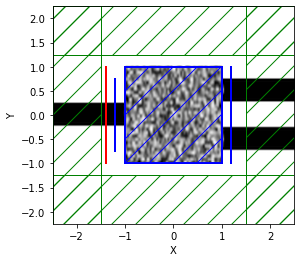

In [7]:
opt.plot2D(True)
plt.show()

In [8]:
f0, dJ_deps, dg = opt()

Starting forward run...
Starting adjoint run...
Calculating gradient...


In [9]:
g_adjoint = np.sum(design_variables.get_basis_vjp(dJ_deps,dg),axis=1)

In [10]:
db = 1e-3
choose = 20
g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose,db=db)

1.0980491971303046


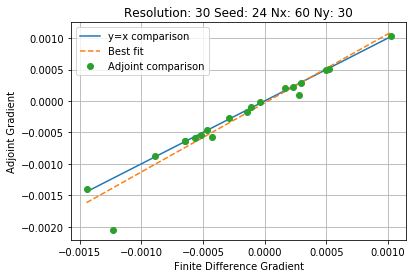

In [11]:
(m, b) = np.polyfit(np.squeeze(g_discrete), g_adjoint[idx], 1)
print(m)

min_g = np.min(g_discrete)
max_g = np.max(g_discrete)

plt.figure()
plt.plot([min_g, max_g],[min_g, max_g],label='y=x comparison')
plt.plot([min_g, max_g],[m*min_g+b, m*max_g+b],'--',label='Best fit')
plt.plot(g_discrete,g_adjoint[idx],'o',label='Adjoint comparison')
plt.xlabel('Finite Difference Gradient')
plt.ylabel('Adjoint Gradient')
plt.title('Resolution: {} Seed: {} Nx: {} Ny: {}'.format(resolution,seed,Nx,Ny))
plt.legend()
plt.grid(True)
plt.show()